<font size=6>**Loan Application Status Prediction**

<font size=5>**Problem Statement:**<br> <font size=3>This dataset includes details of applicants who have applied for loan. The dataset includes details like credit history, loan amount, their income, dependents etc.

<font size=4>**Independent Variables**

- Loan_ID

- Gender

- Married

- Dependents

- Education

- Self_Employed

- ApplicantIncome

- CoapplicantIncome

- Loan_Amount

- Loan_Amount_Term

- Credit History

- Property_Area

<font size=4>**Dependent Variable (Target Variable):**

- Loan_Status

You have to build a model that can predict whether the loan of the applicant will be approved or not on the basis of the details provided in the dataset. 

<font size=5>**Importing all the necessary libraries**

In [1]:
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
import joblib

import pandas as pd
import numpy as np
import seaborn as sns
import missingno
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import zscore

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgb

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [2]:
df=pd.read_csv(r"https://raw.githubusercontent.com/dsrscientist/DSData/master/loan_prediction.csv")
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


Checking the first 5 and last 5 rows of our entire dataset. We can see that the total number of rows are 614 and columns are 13 in our dataframe. In our problem statement we are asked to predict the loan status as our label using the remaining columns as our features making this to be a **Classification problem!**

<font size=5>**Exploratory Data Analysis**

In [3]:
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)

Ensuring that in future observations we do not have any truncated information being displayed in our Jupter Notebook.

In [5]:
df.drop("Loan_ID",axis=1,inplace=True)

I am dropping the "Loan_ID" column since I feel it is pretty much useless showing just a list of unique identifiers on each row without adding much insight into the prediction of our target label.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB


Using the info method we can see that there are 4 columns with float data type, 1 column with integer data type and 7 columns that have object data type. We will try to spearate these columns into numeric and object datatypes for easier analysis.

<font size=4>**Getting list of object data type column name**

In [7]:
object_datatype = []
for x in df.dtypes.index:
    if df.dtypes[x] == 'object':
        object_datatype.append(x)
print(f"Object Data Type Columns are:\n", object_datatype)

Object Data Type Columns are:
 ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']


<font size=4>**Getting the list of float data type column names**

In [8]:
number_datatype = []
for x in df.dtypes.index:
    if df.dtypes[x] == 'float64' or df.dtypes[x] == 'int64':
        number_datatype.append(x)
print(f"\nNumber Data Type Columns are:\n", number_datatype)


Number Data Type Columns are:
 ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']


We have successfully bifurcated the object datatype column names and numeric data type column names. Since we do not have to worry about outliers and skewness in categorical columns we can use this separated column names to pre process data only on numerical continous columns.

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,592.0,146.412162,85.587325,9.0,100.0,128.0,168.00,700.0
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.00,480.0
Credit_History,564.0,0.842199,0.364878,0.0,1.0,1.0,1.00,1.0


Using the describe method we can take a look at the numerical data type columns and observe the distribution of float and integer data amongst them. The first column counts the total number of rows present in each column and we can see the numbers mismatching the count indicating absence of data in them. Similarly, the mean column gives the average mean information of the columns, the std column shows the standard deviation data, min provides the minimum data present in the numeric columns, 25%-50%-75% gives the first quartile, second quartile and third quartile data for each numeric column and max provides the maximum data present in each of the columns.

In [10]:
df.isna().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

With the isna method we are able to determine the columns that have missing data in them which will need to be treated.

<AxesSubplot:>

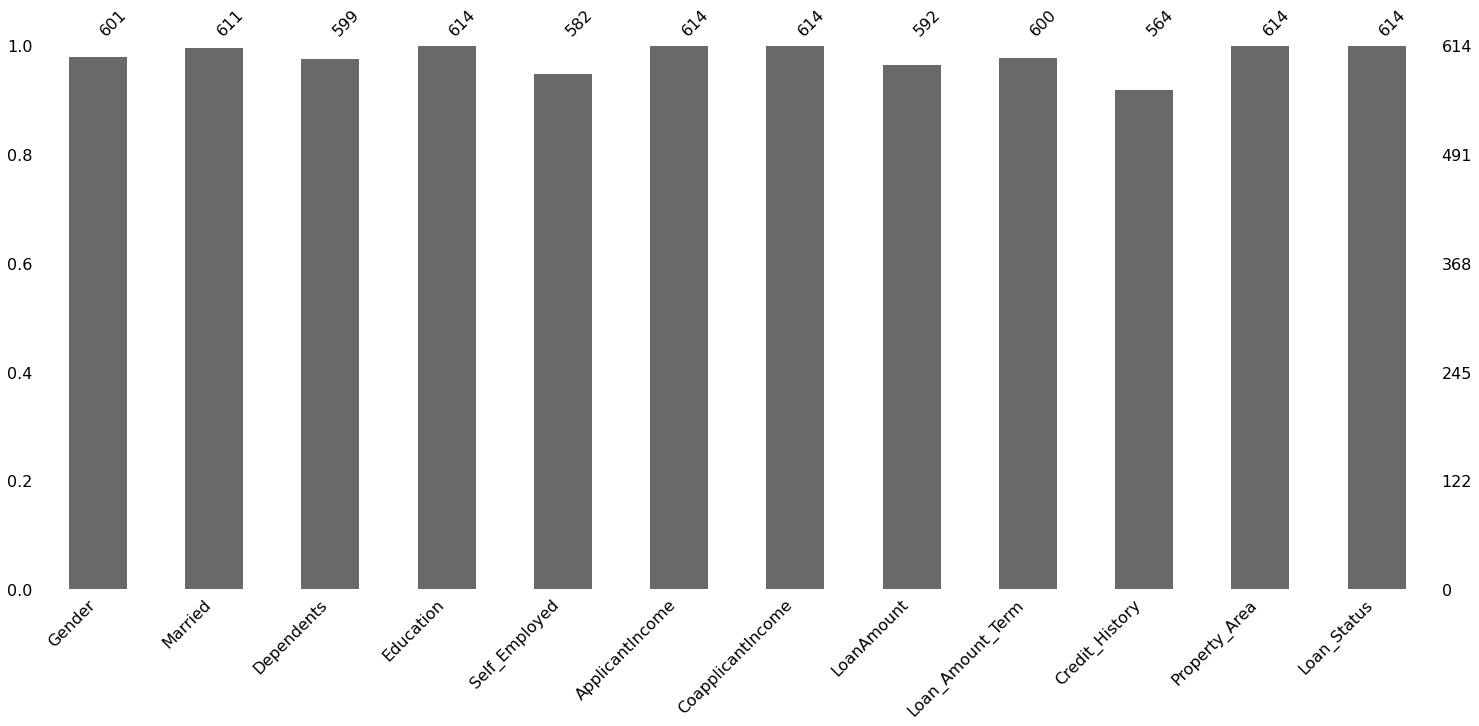

In [11]:
missingno.bar(df,figsize=(25,10))

We are able to depict the missing values information in a bar plot format where we can clearly see that there are null data present in below columns:

1)Gender<br>
2)Married<br>
3)Dependents<br>
4)Self_Employed<br>
5)LoanAmount<br>
6)Loan_Amount_Term<br>
7)Credit_History<br>

In [12]:
df.nunique().to_frame("Unique Values")

,Unique Values
Gender,2
Married,2
Dependents,4
Education,2
Self_Employed,2
ApplicantIncome,505
CoapplicantIncome,287
LoanAmount,203
Loan_Amount_Term,10
Credit_History,2


The nunique method lists down the number of all the unique data present in each column of our dataset.

In [13]:
for col in object_datatype:
    print(col)
    print(df[col].value_counts())
    print("-"*60)

Gender
Male      489
Female    112
Name: Gender, dtype: int64
------------------------------------------------------------
Married
Yes    398
No     213
Name: Married, dtype: int64
------------------------------------------------------------
Dependents
0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64
------------------------------------------------------------
Education
Graduate        480
Not Graduate    134
Name: Education, dtype: int64
------------------------------------------------------------
Self_Employed
No     500
Yes     82
Name: Self_Employed, dtype: int64
------------------------------------------------------------
Property_Area
Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64
------------------------------------------------------------
Loan_Status
Y    422
N    192
Name: Loan_Status, dtype: int64
------------------------------------------------------------


In the above cell we are taking a look at all the unique values of object data type columns. While eye balling the values we were able to see the categories in each columns and the number of rows that cover those data in our entire dataframe.

<font size=5>**Filling all the missing values and treating them with mean and mode**

<font size=4>**filling continous data columns with the mean value of that column**

In [18]:
df["LoanAmount"]=df["LoanAmount"].fillna(df["LoanAmount"].mean())
df["Loan_Amount_Term"]= df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mean())

<font size=4>**filling categorical data columns with the mode value of that column**

In [15]:
df['Credit_History']=df['Credit_History'].fillna(df['Credit_History'].mode()[0])
df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])
df['Married'] = df['Married'].fillna(df['Married'].mode()[0])
df['Dependents'] = df['Dependents'].fillna(df['Dependents'].mode()[0])
df['Self_Employed'] = df['Self_Employed'].fillna(df['Self_Employed'].mode()[0])

I have filled all the missing values in continous data columns using the mean value of those columns and all the missing data in categorical columns with the mode of those columns.

In [19]:
df.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

We can see that all the missing data has been filled successfully into our dataset.

<font size=6>**Visualization**

In [20]:
print(f"Object Data Type Column Names: \n", object_datatype)
print(f"\nNumeric Data Type Column Names: \n", number_datatype)

Object Data Type Column Names: 
 ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']

Numeric Data Type Column Names: 
 ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']


Lisiting out the column names for object datatype and numeric datatype respectively.

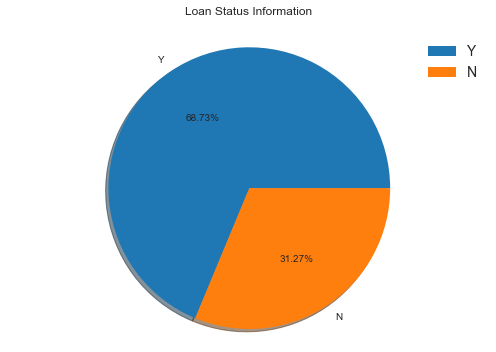

In [21]:
plt.style.use('seaborn-white')
plt.figure(figsize=(7,5))
plt.pie(df['Loan_Status'].value_counts(), labels=df['Loan_Status'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title('Loan Status Information\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()

In the above pie chart we can see that our target label has 68.73% of loan approved status while 31.27% of loan rejected status. This indicated a class imbalance that will need to be treated before building our machine learning models.

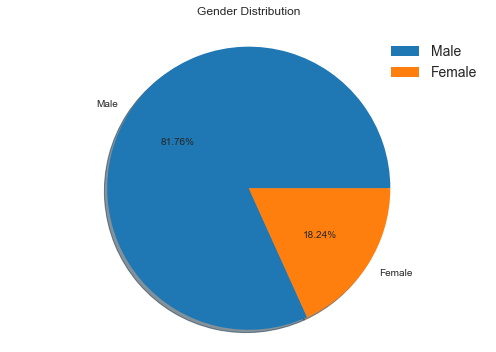

In [22]:
plt.figure(figsize=(7,5))
plt.pie(df['Gender'].value_counts(), labels=df['Gender'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title('Gender Distribution\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()

In the above pie chart we can see that the number of males cover 81.76% of the rows in Gender column while females cover only 18.24% of rows.

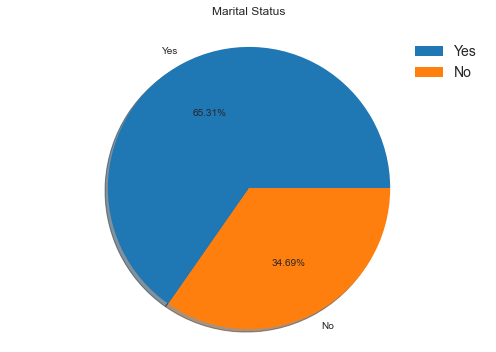

In [23]:
plt.figure(figsize=(7,5))
plt.pie(df['Married'].value_counts(), labels=df['Married'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title('Marital Status\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()

In the above pie chart we can see that 65.31% of rows in Married column are filled with married people and the remaining 34.69% of rows are filled with unmarried people.

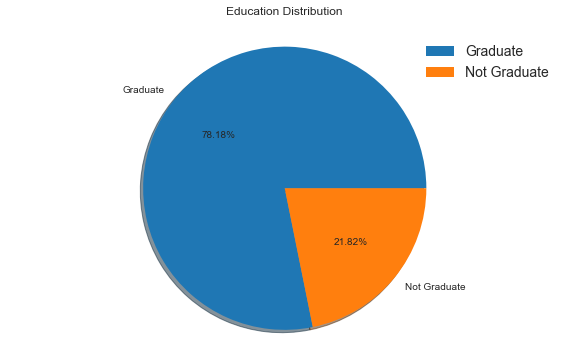

In [24]:
plt.figure(figsize=(8,5))
plt.pie(df['Education'].value_counts(), labels=df['Education'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title('Education Distribution\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()

In the above pie chart we can see that 78.18% of rows present in Education column are filled with graduates while the remaining 21.82% rows are filled with under graduate people.

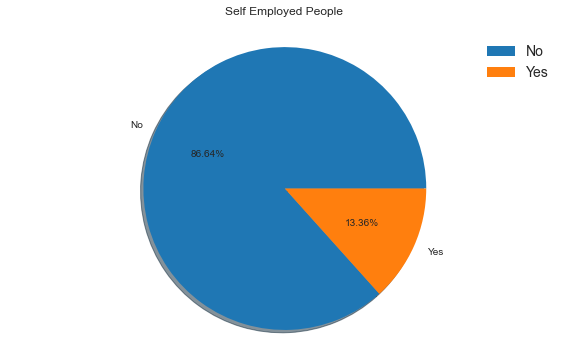

In [25]:
plt.figure(figsize=(8,5))
plt.pie(df['Self_Employed'].value_counts(), labels=df['Self_Employed'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title('Self Employed People\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()

In the above pie chart we can see that 86.64% people are not self employed and might be working with either private or government sectors while only 13.36% people are self employed owning their businesses.

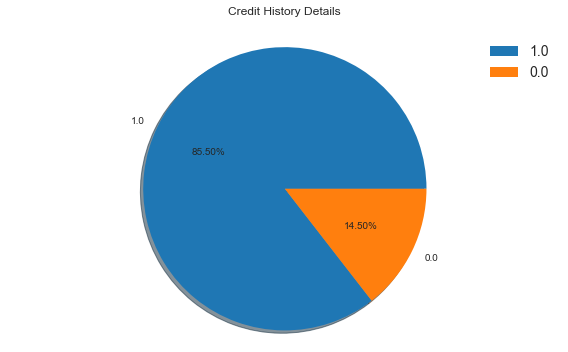

In [26]:
plt.figure(figsize=(8,5))
plt.pie(df['Credit_History'].value_counts(), labels=df['Credit_History'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title('Credit History Details\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()

In the above pie chart we can see that 1.0 represent that credit history is available and 0.0 represent that credit history is not available. For 85.50% of people we have the credit history information available while 14.50% people do not have any credit history.

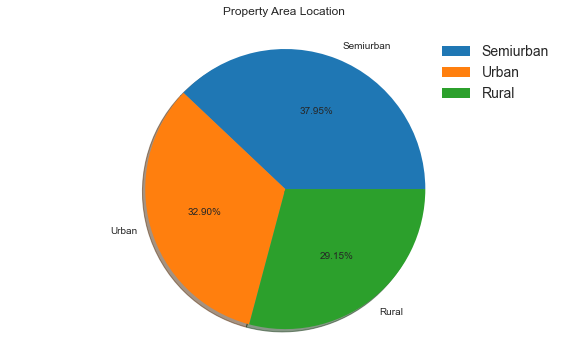

In [27]:
plt.figure(figsize=(8,5))
plt.pie(df['Property_Area'].value_counts(), labels=df['Property_Area'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title('Property Area Location\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()

In the above pie chart we can see that 37.95% rows are covered by semi urban area type, 32.90% rows are covered by urban area type and 29.15% rows are covered by rural area type in our property area column.

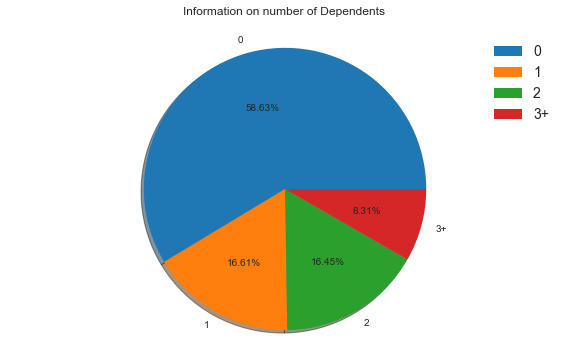

In [28]:
plt.figure(figsize=(8,5))
plt.pie(df['Dependents'].value_counts(), labels=df['Dependents'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title('Information on number of Dependents\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()


In the above pie chart we can see the total number of dependants where 56.63% rows are covered with people having 0 dependents, 16.61% rows covered with people having 1 dependent, 16.45% rows covered with people having 2 dependents and 8.31% rows covered with people having 3 or more dependents.

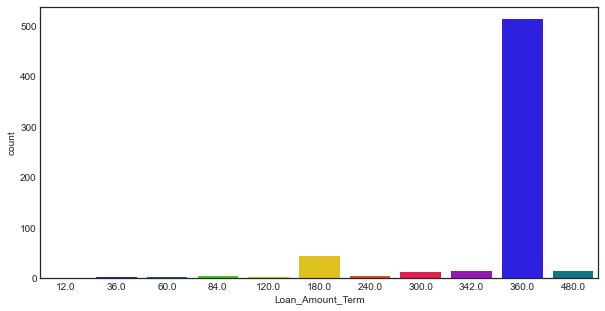

In [29]:
try:
    plt.figure(figsize=(10,5))
    col_name = 'Loan_Amount_Term'
    values = df[col_name].value_counts()
    index = 0
    ax = sns.countplot(df[col_name], palette="prism")
    for i in ax.get_xticklabels():
        ax.text(index, values[i.get_text()]/2, values[i.get_text()], 
                horizontalalignment="center", fontweight='bold', color='w')
        index += 1
    plt.title(f"Count Plot for {col_name}\n")
    plt.ylabel(f"Number of rows")
    plt.xticks(rotation=90)
    plt.show()
    
except Exception as e:
    pass

In the above count plot we can see that the highest number of rows are covered by the value 360.0 in the "Loan_Amount_Term" column.

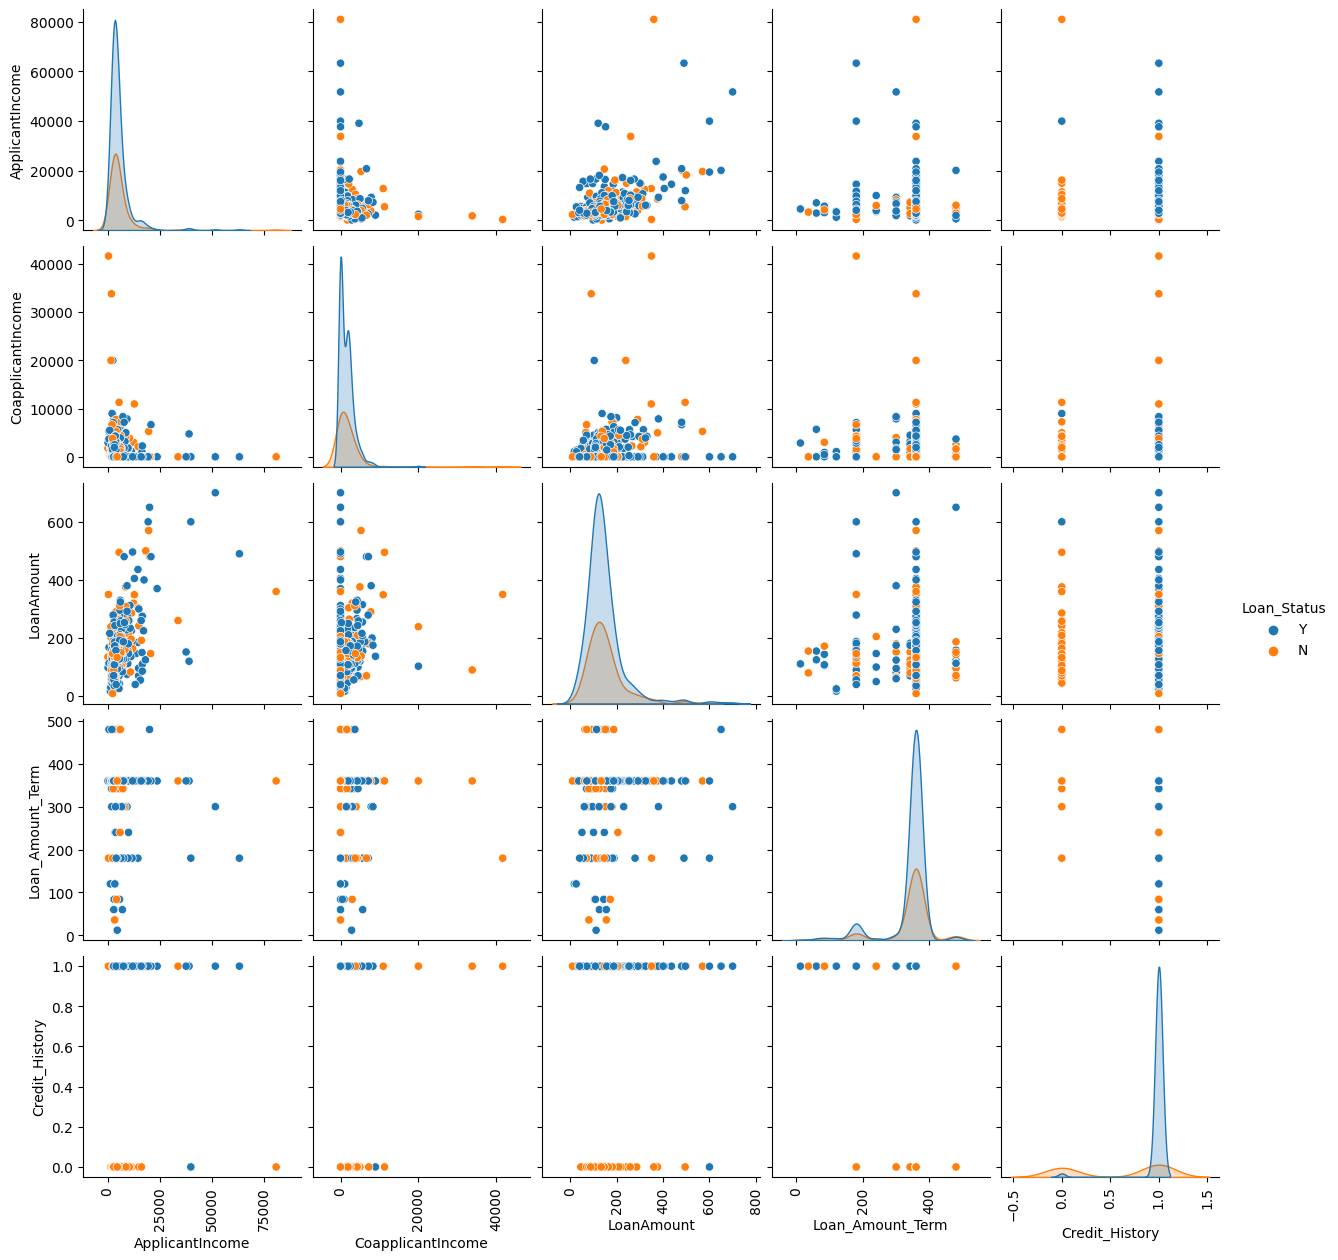

In [30]:
plt.style.use('default')
g = sns.pairplot(df, hue='Loan_Status', diag_kind='kde')
for ax in g.axes.flat:
    ax.tick_params("x", labelrotation=90)
plt.show()

I have generated the above pairplot for our continous data columns that shows us how the data points are distributed in each of the numeric datatype columns.

<AxesSubplot:xlabel='LoanAmount', ylabel='Loan_Amount_Term'>

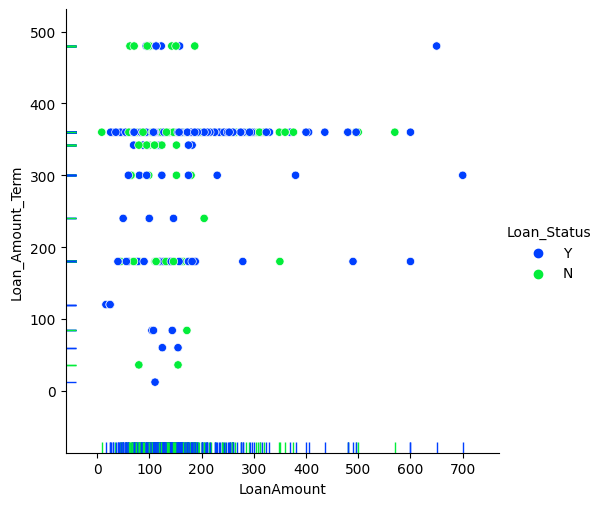

In [31]:
plt.style.use('seaborn-bright')
sns.relplot(data=df, x='LoanAmount', y='Loan_Amount_Term', hue='Loan_Status')
sns.rugplot(data=df, x='LoanAmount', y='Loan_Amount_Term', hue='Loan_Status', legend=False)

In the loan amount vs loan amount term plot we can see that most of the data points are accumulated for 180, 300, 340, 360 and 480 terms while loan amount ranging from 50-250 for a term of 480 mostly seems to be getting rejected than approved.

<AxesSubplot:xlabel='LoanAmount', ylabel='Loan_Amount_Term'>

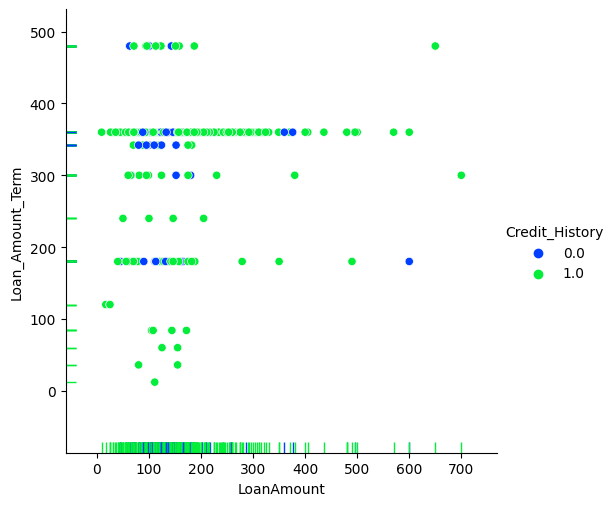

In [32]:
sns.relplot(data=df, x='LoanAmount', y='Loan_Amount_Term', hue='Credit_History')
sns.rugplot(data=df, x='LoanAmount', y='Loan_Amount_Term', hue='Credit_History', legend=False)

In the above plot we can see that in loan amount vs loan amount term datapoints most of the values already have a credit history to showcase.

<AxesSubplot:xlabel='LoanAmount', ylabel='ApplicantIncome'>

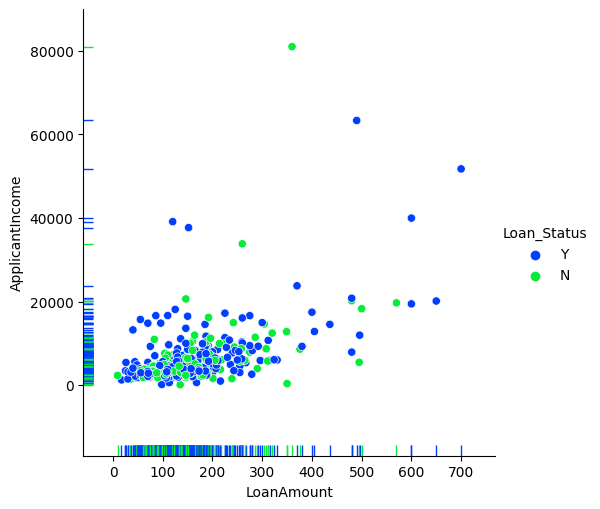

In [33]:
sns.relplot(data=df, x='LoanAmount', y='ApplicantIncome', hue='Loan_Status')
sns.rugplot(data=df, x='LoanAmount', y='ApplicantIncome', hue='Loan_Status', legend=False)

In the above plot we can see that most of the data points are converged near the range 0-20000 data for Applicant Income for mostly loan amount between 0-400

<AxesSubplot:xlabel='LoanAmount', ylabel='ApplicantIncome'>

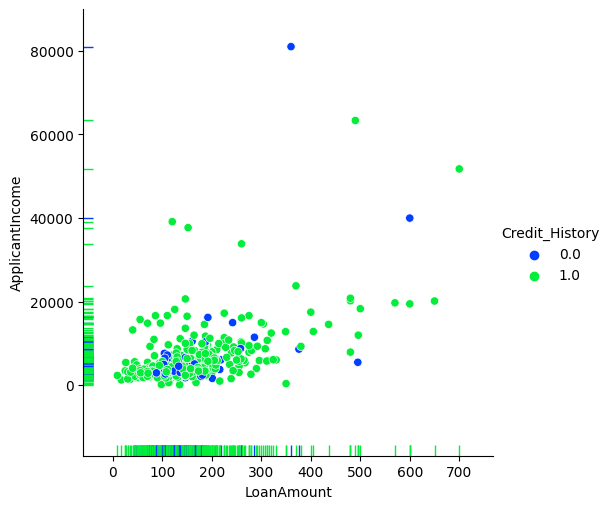

In [34]:
sns.relplot(data=df, x='LoanAmount', y='ApplicantIncome', hue='Credit_History')
sns.rugplot(data=df, x='LoanAmount', y='ApplicantIncome', hue='Credit_History', legend=False)

In the above plot we see that most of the data points have their credit history available and the values are converged between 0-20000 for applicant income and 0-400 for loan amount data

<AxesSubplot:xlabel='LoanAmount', ylabel='CoapplicantIncome'>

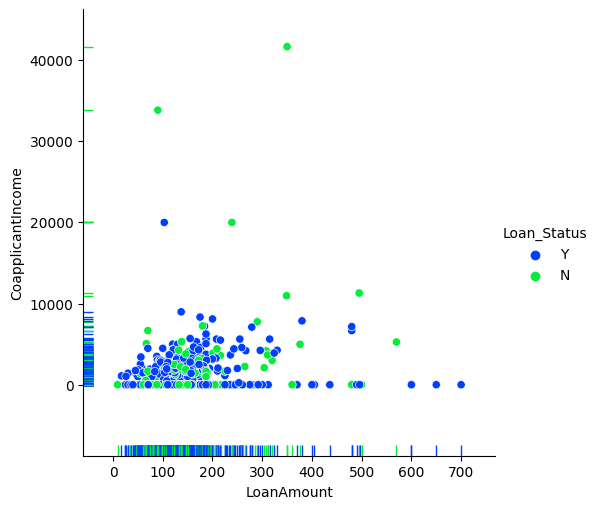

In [35]:
sns.relplot(data=df, x='LoanAmount', y='CoapplicantIncome', hue='Loan_Status')
sns.rugplot(data=df, x='LoanAmount', y='CoapplicantIncome', hue='Loan_Status', legend=False)

In the above plot we see the co applicant income vs loan amount data points where in co applicants with higher income are mostly denied loan where most data values are converged between 0-10000 for co applicant income and 0-300 for loan amount data

<AxesSubplot:xlabel='LoanAmount', ylabel='CoapplicantIncome'>

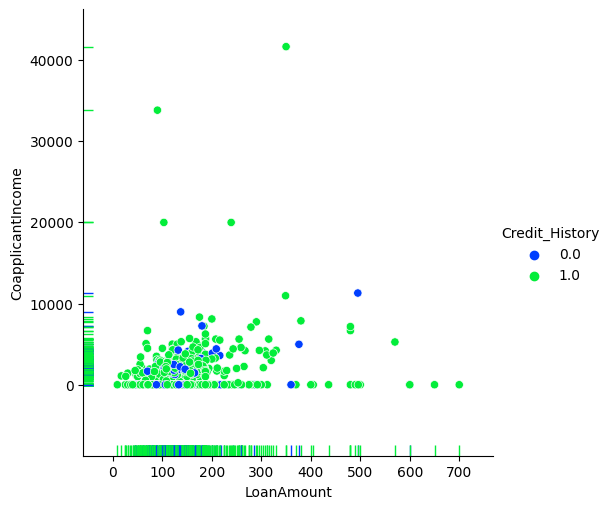

In [36]:
sns.relplot(data=df, x='LoanAmount', y='CoapplicantIncome', hue='Credit_History')
sns.rugplot(data=df, x='LoanAmount', y='CoapplicantIncome', hue='Credit_History', legend=False)

In the above plot we can see that most of the data points are accumulated between 0-10000 for co applicant income and 0-350 for loan amount data and most of these data points have a credit history available for them

<font size=5>**Encoding the categorical object datatype columns**

<font size=4>**Label Encoder**

In [37]:
le = LabelEncoder()
df["Loan_Status"] = le.fit_transform(df["Loan_Status"])
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,1
1,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,0
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,1
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,1
4,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,1


I have used LabelEncoder to convert the object data type in our label column "Loan_Status" to a numerical format.

<font size=4>**Ordinal Encoder**

In [38]:
oe = OrdinalEncoder()
df['Gender'] = oe.fit_transform(df['Gender'].values.reshape(-1,1))
df['Married'] = oe.fit_transform(df['Married'].values.reshape(-1,1))
df['Dependents'] = oe.fit_transform(df['Dependents'].values.reshape(-1,1))
df['Education'] = oe.fit_transform(df['Education'].values.reshape(-1,1))
df['Self_Employed'] = oe.fit_transform(df['Self_Employed'].values.reshape(-1,1))
df['Property_Area'] = oe.fit_transform(df['Property_Area'].values.reshape(-1,1))
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1.0,0.0,0.0,0.0,0.0,5849,0.0,146.412162,360.0,1.0,2.0,1
1,1.0,1.0,1.0,0.0,0.0,4583,1508.0,128.000000,360.0,1.0,0.0,0
2,1.0,1.0,0.0,0.0,1.0,3000,0.0,66.000000,360.0,1.0,2.0,1
3,1.0,1.0,0.0,1.0,0.0,2583,2358.0,120.000000,360.0,1.0,2.0,1
4,1.0,0.0,0.0,0.0,0.0,6000,0.0,141.000000,360.0,1.0,2.0,1


I could have used one hot encoder here but I preferred to use OrdinalEncoder to ensure that the number of columns do not get increased unnecessarily.

In [39]:
print(f"Shape of our data frame post encoding is", df.shape)
df.isna().sum()

Shape of our data frame post encoding is (614, 12)


Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

I am checking the number of rows and columns present in our dataset after applying the enconding techniques and ensuring that there are no null values present in them.

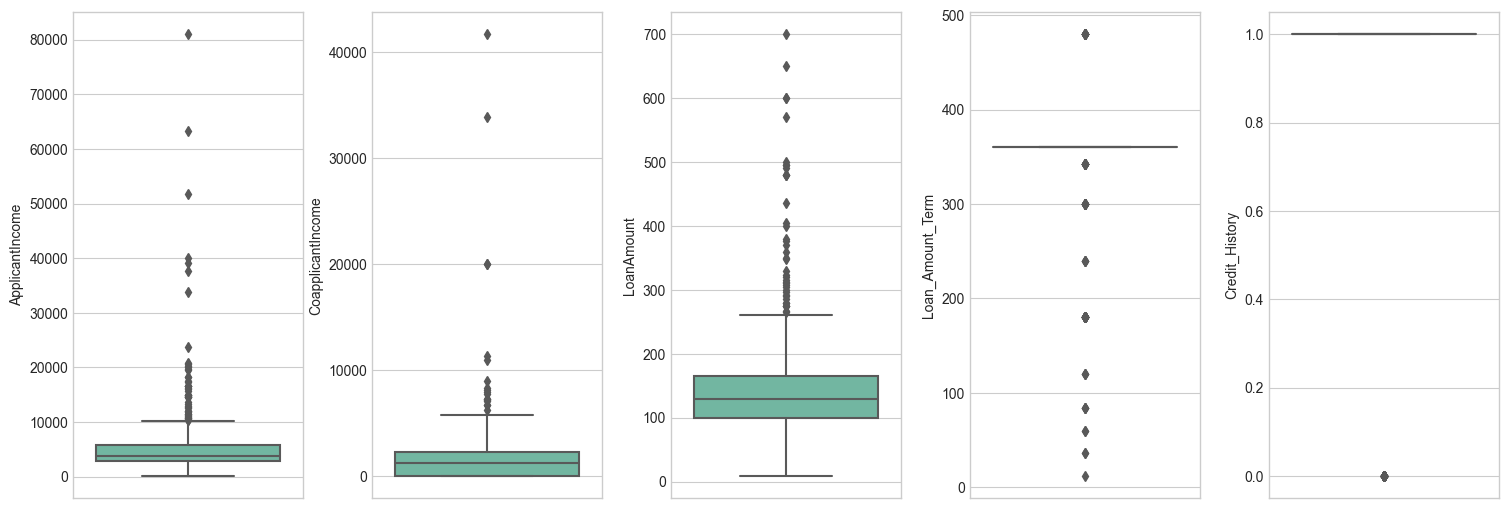

In [40]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(15,5))
index = 0
ax = ax.flatten()
for col, value in df[number_datatype].items():
    sns.boxplot(y=col, data=df, ax=ax[index], palette="Set2")
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.4, h_pad=1.0)
plt.show()

With the help of box plot we can see the outlier details present in our numerical data columns which will need to be treate

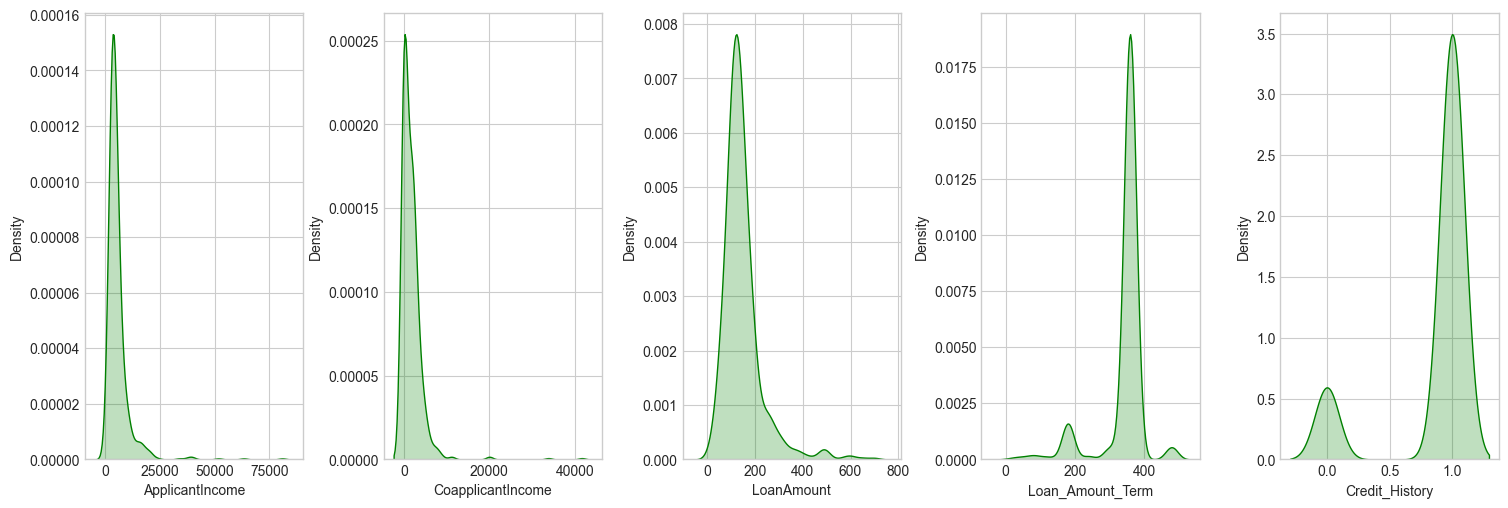

In [44]:
fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(15,5))
index = 0
ax = ax.flatten()
for col, value in df[number_datatype].items():
    sns.distplot(value, ax=ax[index], hist=False, color="g", kde_kws={"shade": True})
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.4, h_pad=1.0)
plt.show()

With the help of distribution plot we can see the skewness details present in our numerical data columns which will need to be treated.

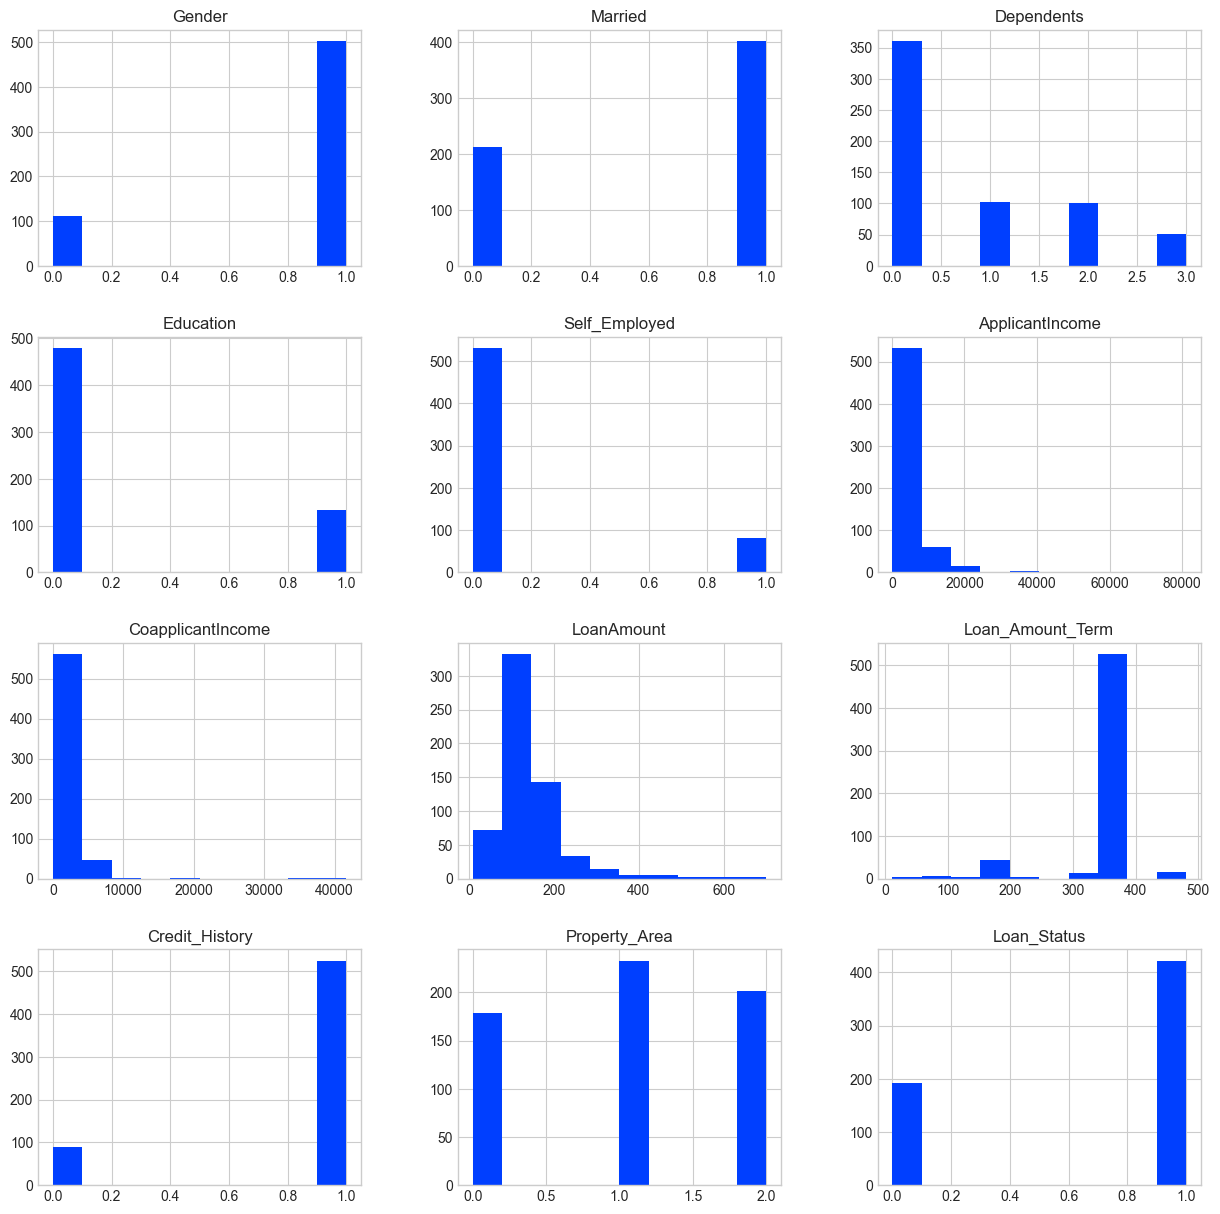

In [42]:
df.hist(figsize=(15,15))
plt.show()

I have generated a histogram for all our dataset columns after applying enconding and converting object datatype to numeric datatype values.

<font size=5>**Correlation Using a Heatmap**

1) Positive correlation - A correlation of +1 indicates a perfect positive correlation, meaning that both variables move in the same direction together.<br>
2) Negative correlation - A correlation of –1 indicates a perfect negative correlation, meaning that as one variable goes up, the other goes down.

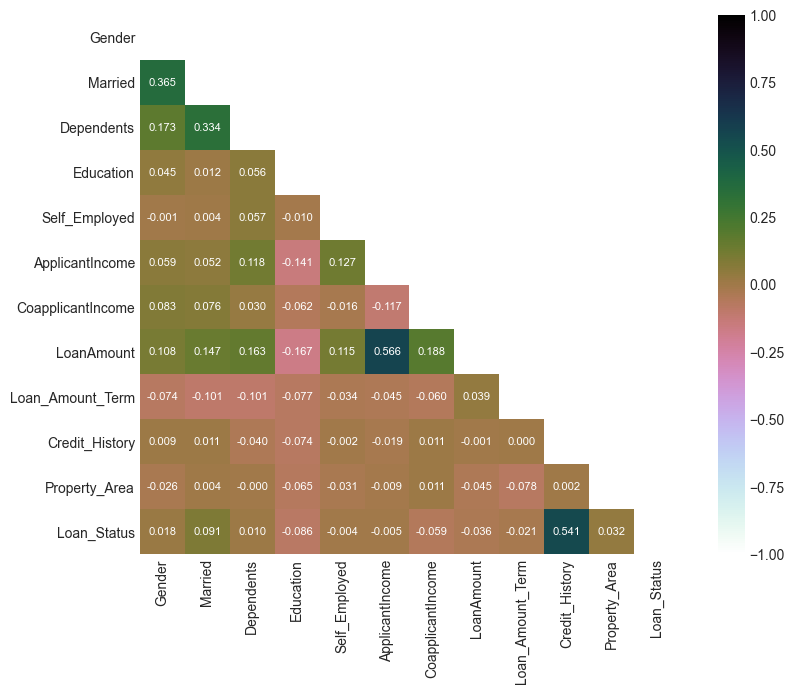

In [45]:
plt.style.use('seaborn-pastel')
upper_triangle = np.triu(df.corr())
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, square=True, fmt='0.3f', 
            annot_kws={'size':8}, cmap="cubehelix_r", mask=upper_triangle)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In the above heatmap we can see the correlation details plus we can determine that there is no multi colinearity issue between our columns.

<font size=5>**Correlation Bar Plot comparing features with our label**

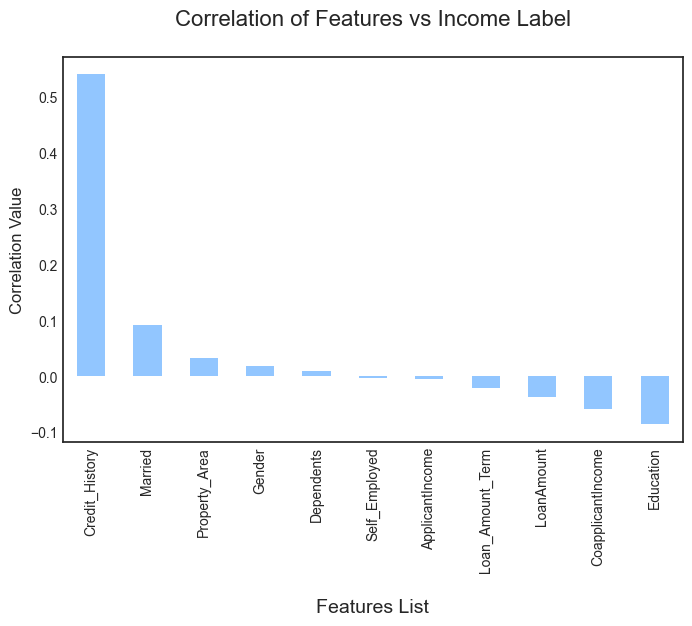

In [46]:
plt.style.use('seaborn-white')
df_corr = df.corr()
plt.figure(figsize=(8,5))
df_corr['Loan_Status'].sort_values(ascending=False).drop('Loan_Status').plot.bar()
plt.title("Correlation of Features vs Income Label\n", fontsize=16)
plt.xlabel("\nFeatures List", fontsize=14)
plt.ylabel("Correlation Value", fontsize=12)
plt.show()

Since the heatmap was not able to give us a clear picture on positive and negative correlation columns we have generated this bar plot and we see that columns loan amount term, loan amount, co applicant income and education are negatively correlated while all the remaining feature columns are positively correlated with our label column.

<font size=5>**Using Z Score to remove outliers**

In [47]:
z = np.abs(zscore(df))
threshold = 3
df1 = df[(z<3).all(axis = 1)]

print ("Shape of the dataframe before removing outliers: ", df.shape)
print ("Shape of the dataframe after removing outliers: ", df1.shape)
print ("Percentage of data loss post outlier removal: ", (df.shape[0]-df1.shape[0])/df.shape[0]*100)

df=df1.copy()

Shape of the dataframe before removing outliers:  (614, 12)
Shape of the dataframe after removing outliers:  (577, 12)
Percentage of data loss post outlier removal:  6.026058631921824


I have used the Z score method to remove the outliers and the percent of data lost is 6.026058631921824 which is below 10 percent that we could have afforded to lose.

In [48]:
df.skew()

Gender              -1.622920
Married             -0.630211
Dependents           1.052106
Education            1.306588
Self_Employed        2.252848
ApplicantIncome      2.148522
CoapplicantIncome    1.350517
LoanAmount           1.113132
Loan_Amount_Term    -2.077031
Credit_History      -1.976043
Property_Area       -0.055332
Loan_Status         -0.822635
dtype: float64

With the skew method we see that there are columns present in our dataset that are above the acceptable range of +/-0.5 value.

<font size=5>**Using Log Transform to fix skewness**

In [49]:
for col in number_datatype:
    if df.skew().loc[col]>0.55:
        df[col]=np.log1p(df[col])

I have applied Log Transformation on our numerical datatype columns to ensure that we do not have skewness in our dataset.

In [50]:
df.skew()

Gender              -1.622920
Married             -0.630211
Dependents           1.052106
Education            1.306588
Self_Employed        2.252848
ApplicantIncome     -0.204913
CoapplicantIncome   -0.216757
LoanAmount          -0.697883
Loan_Amount_Term    -2.077031
Credit_History      -1.976043
Property_Area       -0.055332
Loan_Status         -0.822635
dtype: float64

We have managed to reduce the skewness from our numerical columns which can be seen above while we have ignored the skewness and outlier details for our categorical columns.

<font size=5>**Splitting the dataset into 2 variables namely 'X' and 'Y' for feature and label**

In [51]:
X = df.drop('Loan_Status', axis=1)
Y = df['Loan_Status']

I have bifurcated the dataset into features and labels where X represents all the feature columns and Y represents the target label column.

<font size=5>**Resolving the class imbalance issue in our label column**

In [52]:
Y.value_counts()

1    398
0    179
Name: Loan_Status, dtype: int64

Listing the values of our label column to count the number of rows occupied by each category. This indicates class imbalance that we will need to fix by using the oversampling method.

<font size=4>**adding samples to make all the categorical label values same**

In [53]:
oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

SMOTE is the over sampling mechanism that we are using to ensure that all the categories present in our target label have the same value.

In [54]:
Y.value_counts()

0    398
1    398
Name: Loan_Status, dtype: int64

After applying over sampling we are once again listing the values of our label column to cross verify the updated information. Here we see that we have successfully resolved the class imbalance problem and now all the categories have same data ensuring that the machine learning model does not get biased towards one category.

<font size=5>**Feature Scaling**

In [55]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,0.475567,-1.352052,-0.723516,-0.583927,-0.376675,0.714955,-1.136387,0.357063,0.222621,0.586011,1.223745
1,0.475567,0.782626,0.317650,-0.583927,-0.376675,0.266537,0.783416,0.027665,0.222621,0.586011,-1.308386
2,0.475567,0.782626,-0.723516,-0.583927,2.819277,-0.512411,-1.136387,-1.589745,0.222621,0.586011,1.223745
3,0.475567,0.782626,-0.723516,1.826017,-0.376675,-0.787502,0.900608,-0.130397,0.222621,0.586011,1.223745
4,0.475567,-1.352052,-0.723516,-0.583927,-0.376675,0.761815,-1.136387,0.264713,0.222621,0.586011,1.223745


I am scaling my feature data to ensure that there is no issue with the data biasness over a particular column instead a standardization will occur helping us in having a uniform dataset value.

<font size=5>**Finding best random state for building Classification Models**

In [56]:
maxAccu=0
maxRS=0

for i in range(1, 1000):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=i)
    lr=LogisticRegression()
    lr.fit(X_train, Y_train)
    pred = lr.predict(X_test)
    acc_score = (accuracy_score(Y_test, pred))*100
    
    if acc_score>maxAccu:
        maxAccu=acc_score
        maxRS=i

print("Best accuracy score is", maxAccu,"on Random State", maxRS)

Best accuracy score is 84.42211055276381 on Random State 719


<font size=5>**Feature importance bar graph**

,Importance
Features,
Credit_History,0.305
ApplicantIncome,0.161
LoanAmount,0.152
CoapplicantIncome,0.101
Property_Area,0.067
Dependents,0.053
Married,0.048
Education,0.042
Loan_Amount_Term,0.033


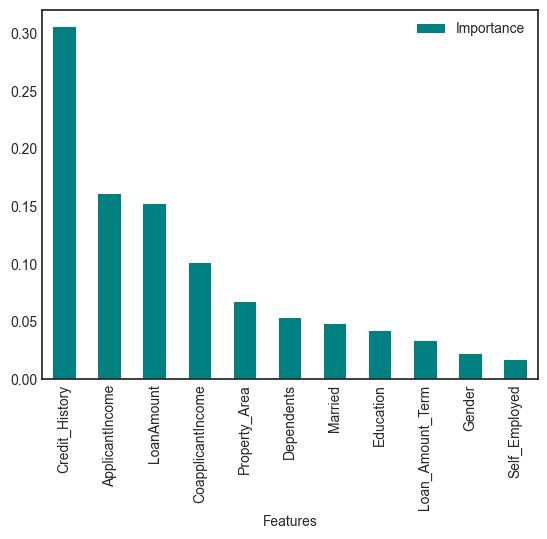

In [57]:
rf=RandomForestClassifier()
rf.fit(X_train, Y_train)
importances = pd.DataFrame({'Features':X.columns, 'Importance':np.round(rf.feature_importances_,3)})
importances = importances.sort_values('Importance', ascending=False).set_index('Features')
importances.plot.bar(color='teal')
importances

Here with the help of RandomForestClassifier we are able to list down the importance or priority given to a column as per it's involvement or weightage in predicting our label.

<font size=5>**Machine Learning Model for Classification with Evaluation Metrics**

In [58]:
def classify(model, X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=719)
    
    # Training the model
    model.fit(X_train, Y_train)
    
    # Predicting Y_test
    pred = model.predict(X_test)
    
    # Classification Report
    class_report = classification_report(Y_test, pred)
    print("\nClassification Report:\n", class_report)
    
    # Accuracy Score
    acc_score = (accuracy_score(Y_test, pred))*100
    print("Accuracy Score:", acc_score)
    
    # Cross Validation Score
    cv_score = (cross_val_score(model, X, Y, cv=5).mean())*100
    print("Cross Validation Score:", cv_score)
    
    # Result of accuracy minus cv scores
    result = acc_score - cv_score
    print("\nAccuracy Score - Cross Validation Score is", result)

I have defined a class that will perform the train-test split, training of machine learning model, predicting the label value, getting the accuracy score, generating the classification report, getting the cross validation score and the result of difference between the accuracy score and cross validation score for any machine learning model that calls for this function.

<font size=4>**Logistic Regression**

In [59]:
model=LogisticRegression()
classify(model, X, Y)



Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.75      0.85       115
           1       0.74      0.98      0.84        84

    accuracy                           0.84       199
   macro avg       0.86      0.86      0.84       199
weighted avg       0.88      0.84      0.84       199

Accuracy Score: 84.42211055276381
Cross Validation Score: 75.13364779874215

Accuracy Score - Cross Validation Score is 9.288462754021666


<font size=4>**Support Vector Classifier**

In [60]:
model=SVC(C=1.0, kernel='rbf', gamma='auto', random_state=42)
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.81      0.88       115
           1       0.78      0.95      0.86        84

    accuracy                           0.87       199
   macro avg       0.87      0.88      0.87       199
weighted avg       0.89      0.87      0.87       199

Accuracy Score: 86.93467336683418
Cross Validation Score: 76.13679245283018

Accuracy Score - Cross Validation Score is 10.797880914003997


<font size=4>**Decision Tree Classifier**

In [61]:
model=DecisionTreeClassifier(random_state=21, max_depth=15)
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84       115
           1       0.78      0.77      0.78        84

    accuracy                           0.81       199
   macro avg       0.81      0.81      0.81       199
weighted avg       0.81      0.81      0.81       199

Accuracy Score: 81.4070351758794
Cross Validation Score: 77.76729559748428

Accuracy Score - Cross Validation Score is 3.6397395783951225


<font size=4>**Random Forest Classifier**

In [62]:
model=RandomForestClassifier(max_depth=15, random_state=111)
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.87      0.91       115
           1       0.84      0.95      0.89        84

    accuracy                           0.90       199
   macro avg       0.90      0.91      0.90       199
weighted avg       0.91      0.90      0.91       199

Accuracy Score: 90.45226130653266
Cross Validation Score: 84.55896226415094

Accuracy Score - Cross Validation Score is 5.893299042381727


<font size=4>**K Neighbors Classifier**

In [63]:
model=KNeighborsClassifier(n_neighbors=15)
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.72      0.81       115
           1       0.70      0.90      0.79        84

    accuracy                           0.80       199
   macro avg       0.81      0.81      0.80       199
weighted avg       0.82      0.80      0.80       199

Accuracy Score: 79.89949748743719
Cross Validation Score: 74.25

Accuracy Score - Cross Validation Score is 5.649497487437188


<font size=4>**Extra Trees Classifier**

In [64]:
model=ExtraTreesClassifier()
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93       115
           1       0.88      0.95      0.91        84

    accuracy                           0.92       199
   macro avg       0.92      0.93      0.92       199
weighted avg       0.93      0.92      0.92       199

Accuracy Score: 92.46231155778895
Cross Validation Score: 83.67845911949686

Accuracy Score - Cross Validation Score is 8.783852438292087


<font size=4>**XGB Classifier**

In [65]:
model=xgb.XGBClassifier(verbosity=0)
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88       115
           1       0.83      0.87      0.85        84

    accuracy                           0.87       199
   macro avg       0.87      0.87      0.87       199
weighted avg       0.87      0.87      0.87       199

Accuracy Score: 86.93467336683418
Cross Validation Score: 80.0361635220126

Accuracy Score - Cross Validation Score is 6.898509844821575


<font size=4>**LGBM Classifier**

In [66]:
model=lgb.LGBMClassifier()
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.85      0.88       115
           1       0.81      0.87      0.84        84

    accuracy                           0.86       199
   macro avg       0.86      0.86      0.86       199
weighted avg       0.86      0.86      0.86       199

Accuracy Score: 85.92964824120602
Cross Validation Score: 80.4119496855346

Accuracy Score - Cross Validation Score is 5.51769855567143


<font size=5>**Hyper parameter tuning on the best Classification ML Model**

<font size=4>**Choosing Extra Trees Classifier**

In [67]:
fmod_param = {'criterion' : ['gini', 'entropy'],
              'n_jobs' : [-2, -1, 1],
              'random_state' : [42, 739, 1000],
              'max_depth' : [0, 15, 30],
              'n_estimators' : [100, 200, 300]
             }

In [68]:
GSCV = GridSearchCV(ExtraTreesClassifier(), fmod_param, cv=5)

In [69]:
GSCV.fit(X_train,Y_train)

GridSearchCV(cv=5, estimator=ExtraTreesClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [0, 15, 30],
                         'n_estimators': [100, 200, 300], 'n_jobs': [-2, -1, 1],
                         'random_state': [42, 739, 1000]})

In [71]:
GSCV.best_params_

{'criterion': 'gini',
 'max_depth': 30,
 'n_estimators': 100,
 'n_jobs': -2,
 'random_state': 42}

Here the Grid Search CV has provided me with the best parameters list out of all the combinations it used to train the model.

In [72]:
Final_Model = ExtraTreesClassifier(criterion='gini', max_depth=30, n_estimators=100, n_jobs=-2, random_state=42)
Classifier = Final_Model.fit(X_train, Y_train)
fmod_pred = Final_Model.predict(X_test)
fmod_acc = (accuracy_score(Y_test, fmod_pred))*100
print("Accuracy score for the Best Model is:", fmod_acc)

Accuracy score for the Best Model is: 84.42211055276381


I have successfully incorporated the Hyper Parameter Tuning on my Final Model and received the accuracy score for it.

<font size=5>**AUC ROC Curve**

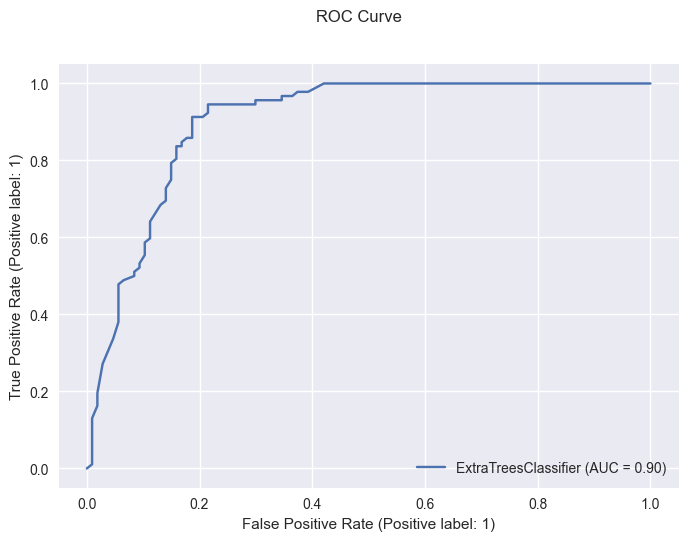

In [74]:
plt.style.use('seaborn')
disp = metrics.plot_roc_curve(Final_Model, X_test, Y_test)
disp.figure_.suptitle("ROC Curve")
plt.show()

I have generated the ROC Curve for my final model and it shows the AUC score for my final model to be of 90%

<font size=5>**Confusion Matrix**

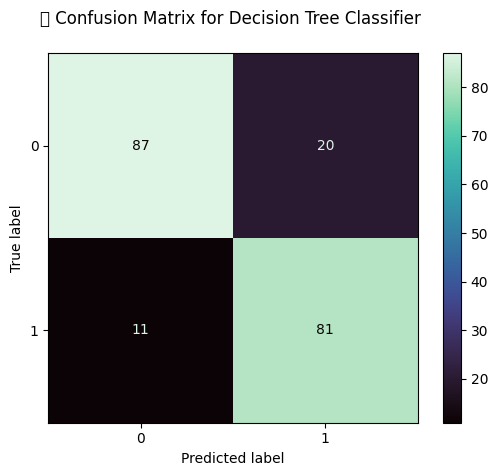

In [75]:
plt.style.use('default')
class_names = df.columns
metrics.plot_confusion_matrix(Classifier, X_test, Y_test, cmap='mako')
plt.title('\t Confusion Matrix for Decision Tree Classifier \n')
plt.show()

With the help of above confusion matrix I am able to understand the number of times I got the correct outputs and the number of times my ML model missed to provide the correct prediction (depicting in the black boxes).

<font size=5>**Saving the Model**

In [76]:
filename = "FinalModel_E06.pkl"
joblib.dump(Final_Model, filename)

['FinalModel_E06.pkl']